In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
import anndata as ad
import scipy as sp

In [2]:
dataset = '16_10x_Visium_Human_Intestine_Cancer'

In [3]:
adata = sq.read.visium(f'../../data/reference_data/{dataset}')

In [4]:
adata

AnnData object with n_obs × n_vars = 2660 × 17943
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [5]:
adata.var_names_make_unique()

In [6]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

In [7]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=30)

In [8]:
adata.layers['counts'] = adata.X.copy()

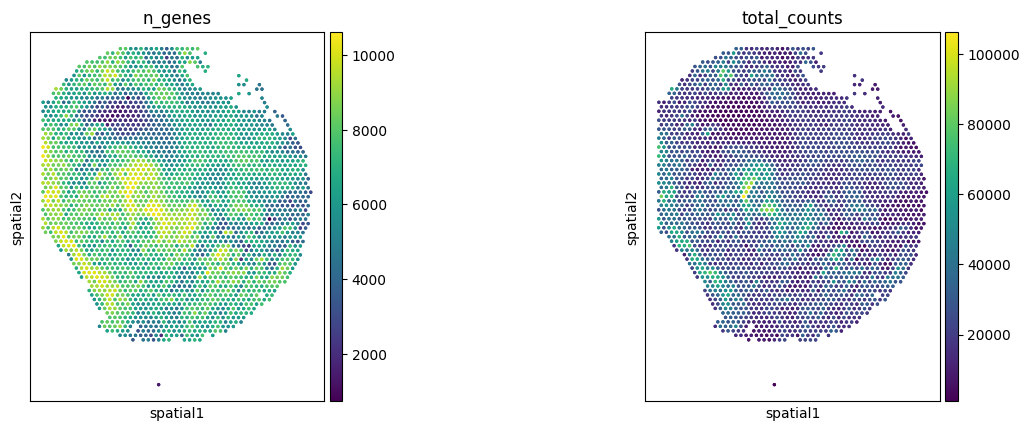

In [9]:
sq.pl.spatial_scatter(adata, color=['n_genes', 'total_counts'], shape=None,
                     size=8)

In [10]:
# remove MT genes
non_mito_genes_list = [name for name in adata.var_names if not name.startswith('MT-')]
adata = adata[:, non_mito_genes_list]

In [11]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [12]:
adata

AnnData object with n_obs × n_vars = 2660 × 14292
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'spatial', 'log1p'
    obsm: 'spatial'
    layers: 'counts'

In [13]:
sq.gr.spatial_neighbors(adata, coord_type="grid", delaunay=False)
sq.gr.spatial_autocorr(adata, mode="moran", 
                       n_perms=100, n_jobs=10, 
                       genes=adata.var_names)

100%|██████████| 100/100 [00:18<00:00,  5.30/s]


In [14]:
adata.uns["moranI"]["I"]

IGHG4       0.879961
IGKC        0.802574
FABP4       0.799041
FN1         0.737428
IGHG1       0.734931
              ...   
SLC4A11    -0.023955
C1QTNF12   -0.023999
RPAP1      -0.024054
ZNF256     -0.024738
OTUD5      -0.024962
Name: I, Length: 14292, dtype: float64

In [15]:
n_svgs = 200
sel_genes = (
    adata.uns["moranI"]["I"].sort_values(ascending=False).head(n_svgs).index.tolist()
)

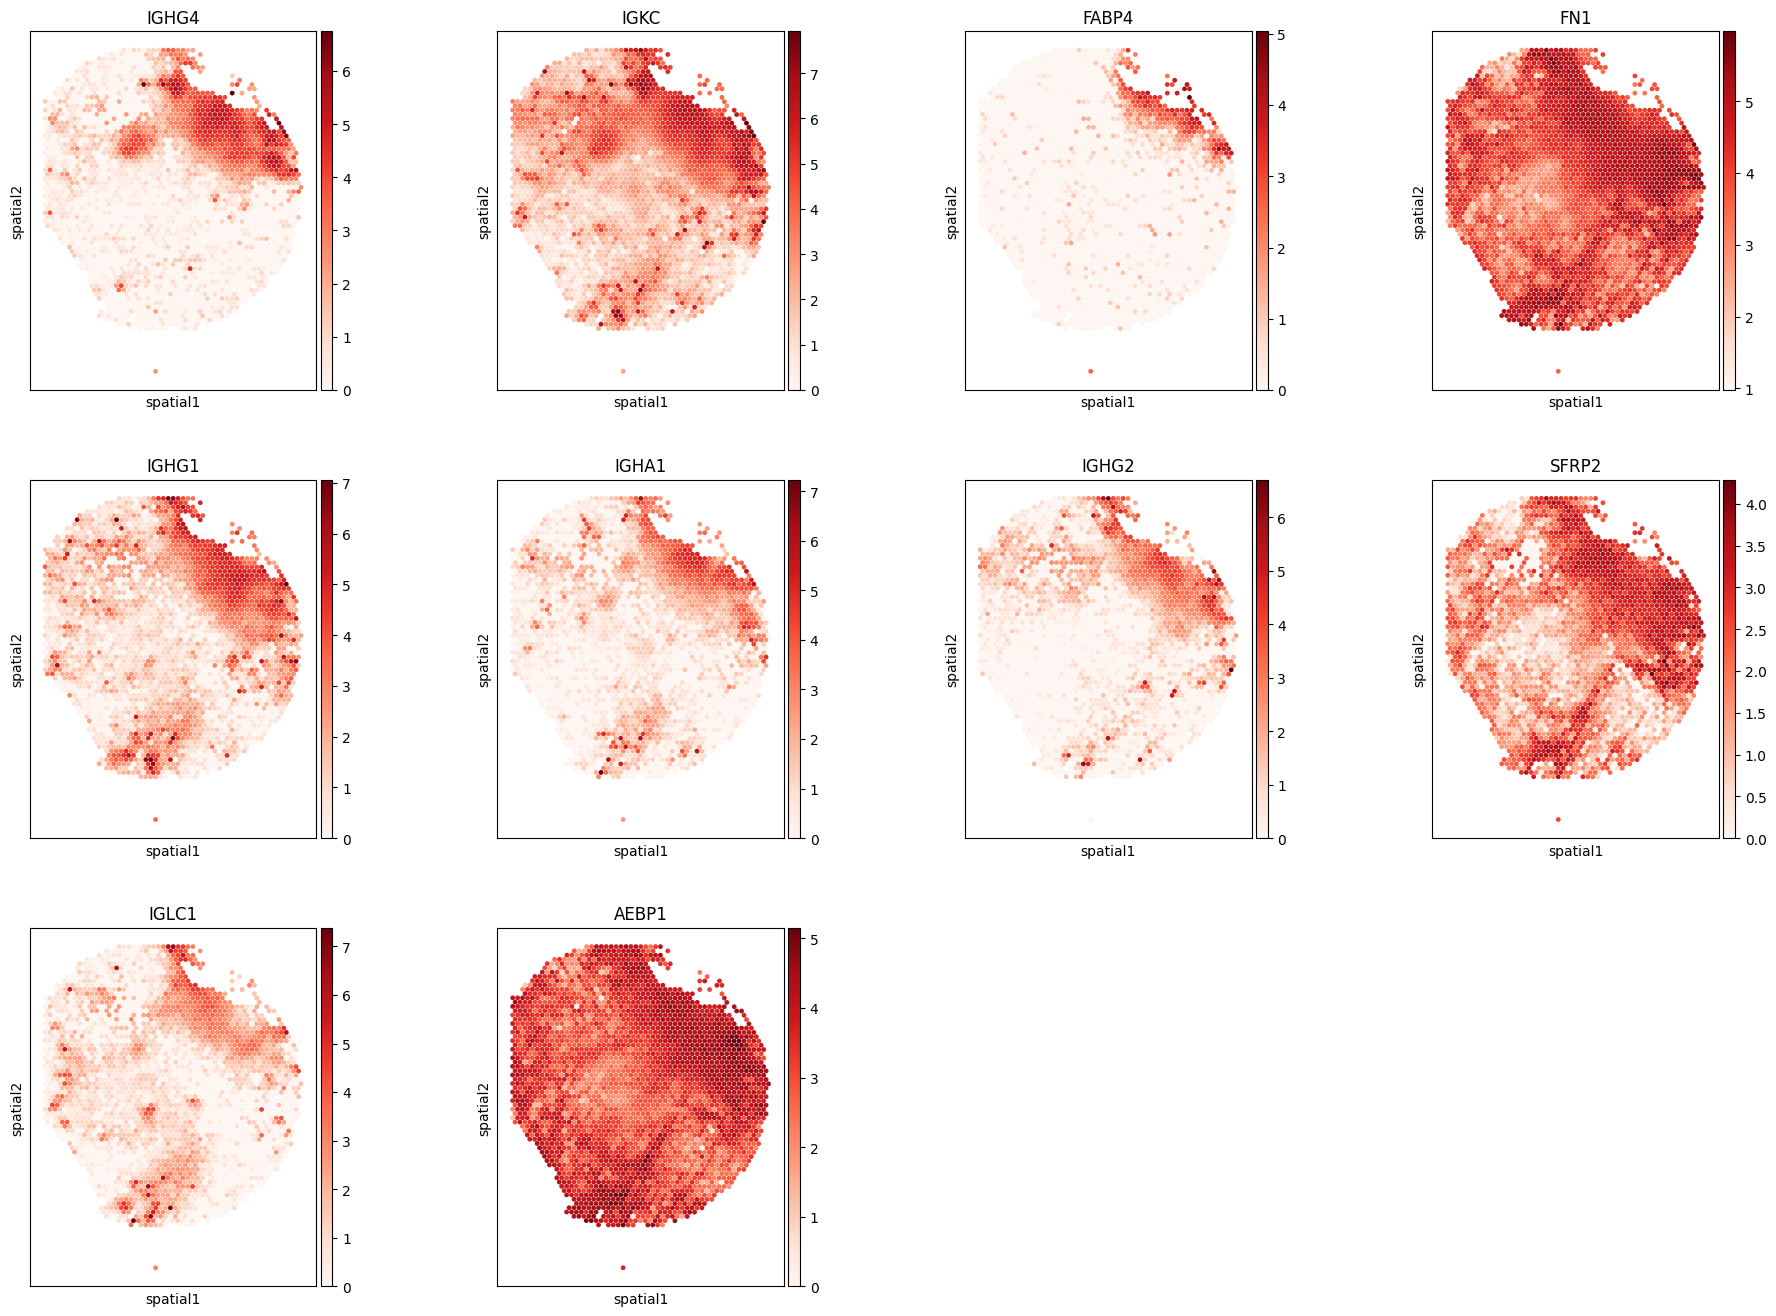

In [16]:
sq.pl.spatial_scatter(
    adata, color=sel_genes[:10], figsize=(5, 5), size=1.5, 
    cmap="Reds", img=False, use_raw=False
)

In [17]:
# select top 50 variable genes as reference
adata = adata[:, sel_genes]

In [18]:
adata

View of AnnData object with n_obs × n_vars = 2660 × 200
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'spatial', 'log1p', 'spatial_neighbors', 'moranI'
    obsm: 'spatial'
    layers: 'counts'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [19]:
adata.write_h5ad(f'../../results/00_prepare_reference_data/{dataset}.h5ad')